In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from scipy import stats

# Data 102 Spring 2024 Lecture 7 Demo

In [2]:
FIGURE_SIZE = (4.5, 3.5)
#def plot_beta_prior_and_posterior(r, s, m, y, show_map=False, show_lmse=False):
def plot_beta_prior_and_posterior(alpha, beta, pos_obs, neg_obs, show_map=False, show_lmse=False, ax=None):   
    x = np.linspace(0, 1, 100)
    prior = stats.beta.pdf(x, alpha, beta)
    
    alpha_new = alpha + pos_obs
    beta_new = beta + neg_obs
    posterior = stats.beta.pdf(x, alpha_new, beta_new)
    
    # You never have to memorize these: when making this notebook,
    # I found them on the wikipedia page for the Beta distribution:
    # https://en.wikipedia.org/wiki/Beta_distribution

    if show_lmse:
        x_lmse = (alpha_new)/(alpha_new + beta_new)
    else:
        x_lmse = None
        
    if show_map:
        x_map = (alpha_new - 1) / (alpha_new + beta_new - 2)
    else:
        x_map = None
    plot_prior_posterior(x, prior, posterior, (-0.02, 1.02),
                         prior_label=f'Prior: Beta({alpha}, {beta})',
                         posterior_label=f'Posterior: Beta({alpha_new}, {beta_new})',
                         x_map=x_map, x_lmse=x_lmse, ax=ax)
    
def plot_prior_posterior(x, prior, posterior, xlim, 
                         prior_label, posterior_label,
                         x_map=None, x_lmse=None, ax=None):
    
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE, dpi=80)
    ax.plot(x, prior, ls=':', lw=2.5, label = prior_label)
    ax.plot(x, posterior, lw=2.5, label = posterior_label)
    if x_map is not None:
        map_index = np.argmin(np.abs(x - x_map))
        posterior_map = posterior[map_index]
        label = f'MAP estimate: {x_map:0.2f}'
        ax.plot([x_map, x_map], [0, posterior_map], '--', lw=2.5, color='black', label=label)
    if x_lmse is not None:
        lmse_index = np.argmin(np.abs(x - x_lmse))
        posterior_lmse = posterior[lmse_index]
        label = f'LMSE estimate: {x_lmse:0.2f}'
        ax.plot([x_lmse, x_lmse], [0, posterior_lmse], '--', lw=1.5, color='red', label=label)
    #plt.legend(bbox_to_anchor=(1.32, 1.02))
    ax.legend()
    ymax = max(max(prior[np.isfinite(prior)]), max(posterior[np.isfinite(posterior)]))
    ax.set_ylim(-0.3, ymax+0.3)
    ax.set_xlim(*xlim)
    ax.set_xlabel('$x$')
    ax.set_title(r'Prior $p(\theta)$ and posterior given observed data $x$: $p(\theta|x)$');
    
    # You don't need to understand how this function is implemented.

def plot_gaussian_prior_and_posterior(μ_0, σ_0, xs, σ, range_in_σs=3.5, show_map=False, show_lmse=False):
    """
    Plots prior and posterior Normaly distribution
    
    Args:
        μ_0, σ_0: parameters (mean, SD) of the prior distribution
        xs: list or array of observations
        σ: SD of the likelihood
        range_in_σs: how many SDs away from the mean to show on the plot
        show_map: whether or not to show the MAP estimate as a vertical line
        show_lmse: whether or not to show the LMSE/MMSE estimate as a vertical line
    """
    n = len(xs)
    posterior_σ = 1/np.sqrt(1/(σ_0**2) + n/(σ**2))
    posterior_mean = (posterior_σ**2) * (μ_0/(σ_0**2) + np.sum(xs)/(σ**2))
    
    # Compute range for plot
    posterior_min = posterior_mean - (range_in_σs * posterior_σ)
    posterior_max = posterior_mean + (range_in_σs * posterior_σ)
    prior_min = μ_0 - (range_in_σs * σ)
    prior_max = μ_0 + (range_in_σs * σ)
    
    xmin = min(posterior_min, prior_min)
    xmax = max(posterior_max, prior_max)
    x = np.linspace(xmin, xmax, 100)
    if show_lmse:
        x_lmse = posterior_mean
    else:
        x_lmse = None
        
    if show_map:
        x_map = posterior_mean
    else:
        x_map = None

    
    prior = stats.norm.pdf(x, μ_0, σ_0)
    posterior = stats.norm.pdf(x, posterior_mean, posterior_σ)
    
    
    plot_prior_posterior(x, prior, posterior, (xmin, xmax), 'Prior', 'Posterior',
                         x_map=x_map, x_lmse=x_lmse)


## Understanding the effect of prior on posterior

### Beta prior + Bernoulli likelihood = Beta posterior

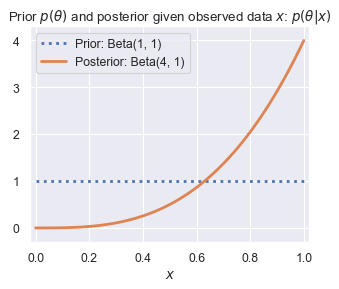

In [3]:
# Plots a Beta distribution with a Beta(1, 1) prior (the first two arguments) 
# and 3 positive observations and 0 negative observations (the second two arguments)

plot_beta_prior_and_posterior(1, 1, 3, 0)


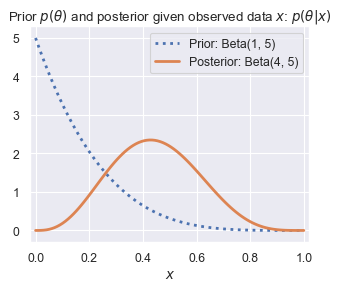

In [4]:
plot_beta_prior_and_posterior(1, 5, 3, 0)

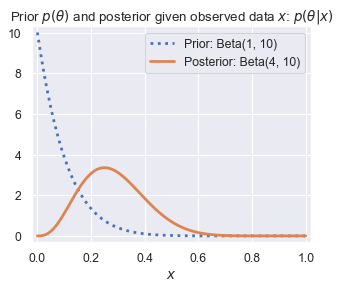

In [5]:
plot_beta_prior_and_posterior(1, 10, 3, 0)

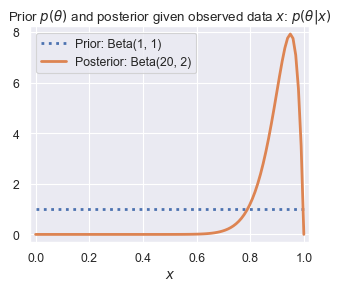

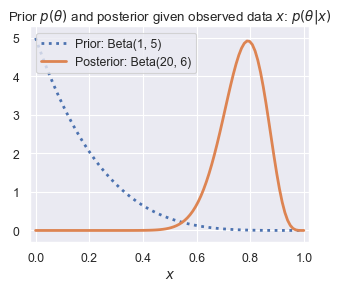

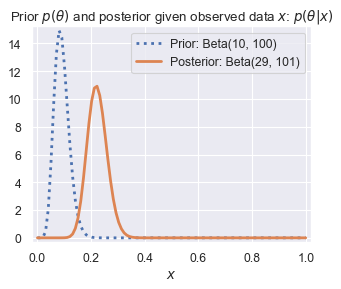

In [6]:
plot_beta_prior_and_posterior(1, 1, 19, 1)
plot_beta_prior_and_posterior(1, 5, 19, 1)
plot_beta_prior_and_posterior(10, 100, 19, 1)

### Gaussian prior (for mean) + Gaussian likelihood = Gaussian posterior

In [7]:
small_sample = [6*12, 6*12+1, 5*12+9]
larger_sample = [6*12, 6*12+1, 5*12+9] * 10

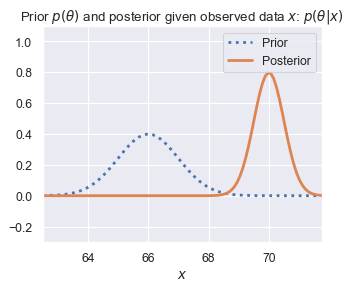

In [8]:
plot_gaussian_prior_and_posterior(5*12+6, 1, small_sample, 1)

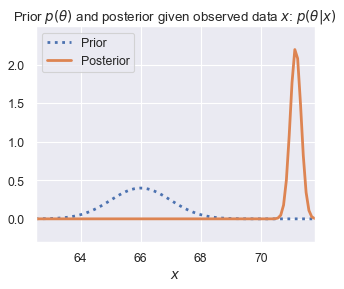

In [9]:
plot_gaussian_prior_and_posterior(5*12+6, 1, larger_sample, 1)

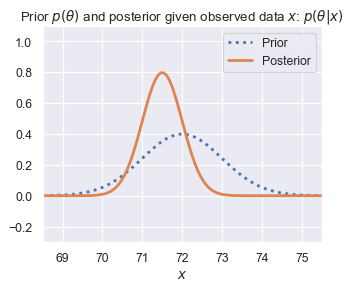

In [10]:
plot_gaussian_prior_and_posterior(6*12, 1, small_sample, 1)

## Bayesian Hierarchical Model for Kidney Cancer

## Data Exploration

We'll focus on the following columns in the kidney cancer dataset:
* `state`: the US state
* `Location`: the county and state as a string
* `fips`, which provides the [FIPS code]() for each county: this is a standard identifier that can often be used to join datasets with county-level information.
* `dc` and `dc.2`: the number of kidney cancer deaths between 1980-1984 and 1985-1989, respectively
* `pop` and `pop.2`: the population between 1980-1984 and 1985-1989, respectively

In [11]:
kc_full = pd.read_csv('kidney_cancer_1980.csv', skiprows=4)
# There are many other interesting columns, but we'll focus on these:
kc = kc_full.loc[:, ['state', 'Location', 'dc', 'dc.2', 'pop', 'pop.2']]
kc.head()

,state,Location,dc,dc.2,pop,pop.2
0,ALABAMA,"Autauga County, Alabama",2,1,61921,64915
1,ALABAMA,"Baldwin County, Alabama",7,15,170945,195253
2,ALABAMA,"Barbour County, Alabama",0,1,33316,33987
3,ALABAMA,"Bibb County, Alabama",0,1,30152,31175
4,ALABAMA,"Blount County, Alabama",3,5,88342,91547


<Axes: xlabel='rate_nopool', ylabel='Count'>

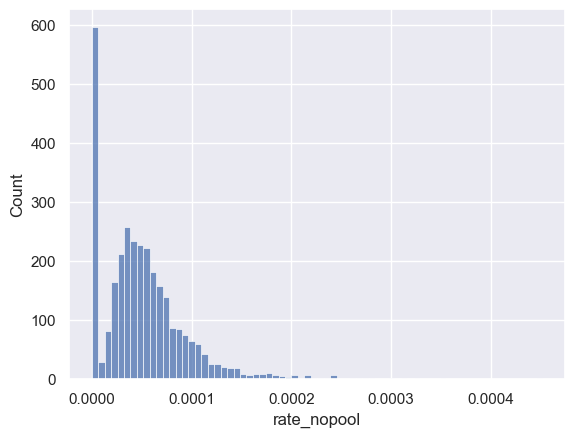

In [12]:
kc['rate_nopool'] = kc['dc'] / kc['pop']
sns.histplot(kc, x='rate_nopool')

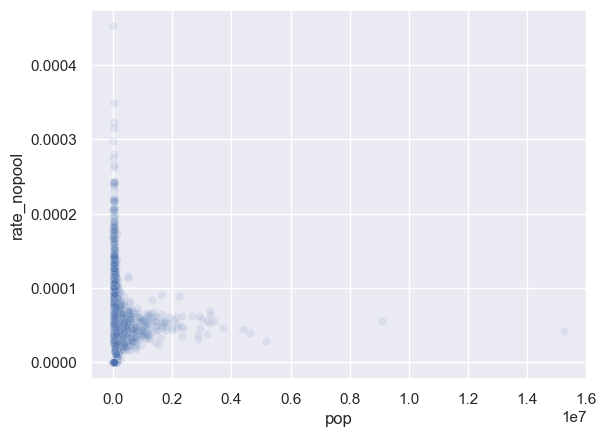

In [13]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.1);

In [14]:
# Complete pooling
total_pop = kc['pop'].sum()
total_dc = kc['dc'].sum()
overall_rate = total_dc / total_pop
overall_rate

4.856485743364176e-05

### Hierarchical model

Prior and likelihood:
$$
\begin{align*}
\theta_i &\sim \mathrm{Beta}(a, b), & i \in \{1, 2, \ldots\} \\
y_i &\sim \mathrm{Binomial}(\theta_i, n_i), & i \in \{1, 2, \ldots\}
\end{align*}
$$

Posterior
$$
\theta_i | y_i \sim \mathrm{Beta}(a + y_i, b + n_i - y_i)
$$



#### Empirical Bayes

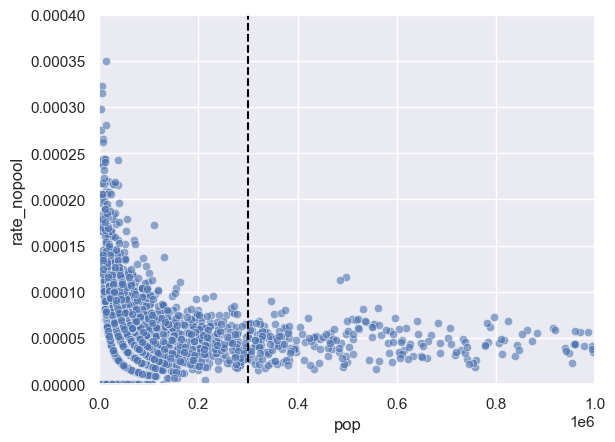

In [15]:
sns.scatterplot(kc, x='pop', y='rate_nopool', alpha=0.6);
plt.vlines(3e5, 0, 0.0004, color='black', ls='--')
plt.axis([0, 1e6, 0, 0.0004]);

<Axes: xlabel='rate_nopool', ylabel='Count'>

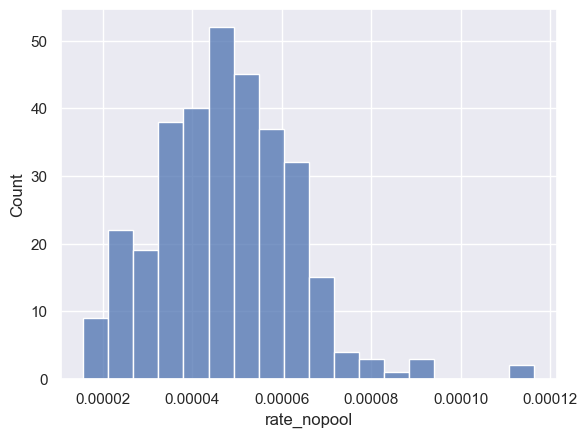

In [16]:

kc_large_counties = kc[kc['pop'] > 300000]
sns.histplot(kc_large_counties, x='rate_nopool')

In [17]:
# Maximum likelihood estimation using scipy: find parameters of a Beta distribution that make the histogram above
# as likely as possible

# The last two arguments tell scipy that it shouldn't try to shift or scale our Beta distribution
a_hat, b_hat, loc_, scale_ = stats.beta.fit(kc_large_counties['rate_nopool'], floc=0, fscale=1)
print(a_hat, b_hat)

9.270228244533358 195581.04114706165


In [18]:
a_guess, b_guess = 5, 19995  # educated guess
a_eb, b_eb = a_hat, b_hat  # empirical bayes

def compute_posterior(kc, prior_a, prior_b):
    posterior_a = prior_a + kc['dc']
    posterior_b = prior_b + (kc['pop'] - kc['dc'])
    return posterior_a, posterior_b
kc['posterior_a_guess'], kc['posterior_b_guess'] = compute_posterior(kc, a_guess, b_guess)
kc['posterior_a_eb'], kc['posterior_b_eb'] = compute_posterior(kc, a_eb, b_eb)

# For a Beta(a, b) distribution, the mean is a / (a + b)
kc['lmse_guess'] = kc['posterior_a_guess'] / (kc['posterior_a_guess'] + kc['posterior_b_guess'])
kc['lmse_eb'] = kc['posterior_a_eb'] / (kc['posterior_a_eb'] + kc['posterior_b_eb'])


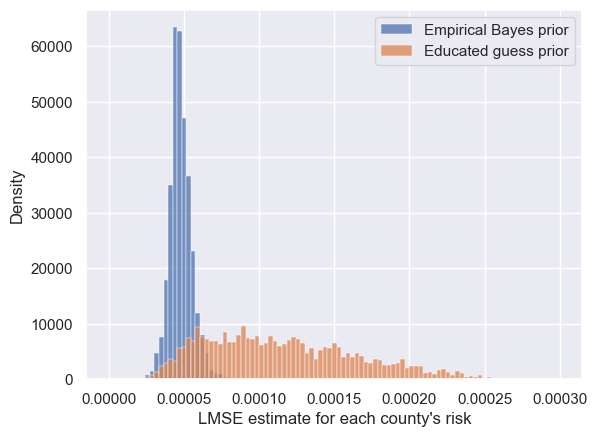

In [19]:
bins = np.linspace(0, 0.0003, 100)
sns.histplot(kc, x='lmse_eb', stat='density', label='Empirical Bayes prior', bins=bins)
sns.histplot(kc, x='lmse_guess',  stat='density', label='Educated guess prior', bins=np.linspace(0, 0.0003, 100))
plt.xlabel("LMSE estimate for each county's risk")
plt.legend()